In [ ]:
# Active Learning: IF + Uncertainty Sampling + Logistic Regression

In [10]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Load data
labeled_df = pd.read_csv("elliptic_txs_features_labeled.csv")

# Split train/test by time_step
train_df = labeled_df[labeled_df['time_step'] <= 34].reset_index(drop=True)
test_df = labeled_df[labeled_df['time_step'] >= 35].reset_index(drop=True)

X_test = test_df.drop(columns=['txId', 'time_step', 'class'])
y_test = (test_df['class'] == 1).astype(int)

feature_columns = [col for col in train_df.columns if col.startswith('feature_') or col.startswith('f')]

# Config
batch_size = 50
max_iterations = 30
N_runs = 5
all_f1_scores = []
warmup_sizes = []
active_sizes = []

for run in range(N_runs):
    print(f"\n=== Run {run+1}/{N_runs} ===")
    unlabeled_pool = train_df.copy()
    labeled_pool = pd.DataFrame(columns=train_df.columns)
    f1_scores = []

    # Warm-up via Isolation Forest
    iso_forest = IsolationForest(n_estimators=25, random_state=run + 42)
    iso_forest.fit(unlabeled_pool[feature_columns])
    scores = -iso_forest.score_samples(unlabeled_pool[feature_columns])
    unlabeled_pool['anomaly_score'] = scores
    unlabeled_pool = unlabeled_pool.sort_values(by='anomaly_score', ascending=False).reset_index(drop=True)

    found_illicit = False
    pointer = 0
    while not found_illicit and pointer < len(unlabeled_pool):
        batch = unlabeled_pool.iloc[pointer:pointer + batch_size]
        labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)
        pointer += batch_size
        found_illicit = (labeled_pool['class'] == 1).sum() > 0

    warmup_size = len(labeled_pool)
    warmup_sizes.append(warmup_size)
    unlabeled_pool = unlabeled_pool.iloc[pointer:].drop(columns='anomaly_score').reset_index(drop=True)

    # Active Learning Loop
    iteration = 1
    while len(unlabeled_pool) > 0 and iteration <= max_iterations:
        X_train = labeled_pool[feature_columns]
        y_train = (labeled_pool['class'] == 1).astype(int)

        model = LogisticRegression(max_iter=300, solver='liblinear', random_state=run + 1)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        f1_scores.append(f1)
        print(f"[Run {run+1}] Iter {iteration} F1-illicit: {f1:.4f}")

        proba = model.predict_proba(unlabeled_pool[feature_columns])[:, 1]
        uncertainty = np.abs(proba - 0.5)
        select_idx = np.argsort(uncertainty)[:batch_size]

        new_batch = unlabeled_pool.iloc[select_idx]
        labeled_pool = pd.concat([labeled_pool, new_batch], ignore_index=True)
        unlabeled_pool = unlabeled_pool.drop(unlabeled_pool.index[select_idx]).reset_index(drop=True)

        iteration += 1

    all_f1_scores.append(f1_scores)
    active_sizes.append(len(f1_scores) * batch_size)

# --- Evaluation ---
max_len = max(len(scores) for scores in all_f1_scores)
f1_matrix = np.full((N_runs, max_len), np.nan)
for i, scores in enumerate(all_f1_scores):
    f1_matrix[i, :len(scores)] = scores

mean_f1_per_iter = np.nanmean(f1_matrix, axis=0)
median_f1_per_iter = np.nanmedian(f1_matrix, axis=0)
final_median_f1 = np.nanmedian([scores[-1] for scores in all_f1_scores if len(scores) == max_len])

print("\n=== Summary ===")
print("Mean F1 per Iteration:", np.round(mean_f1_per_iter, 4))
print("Final Median F1 (illicit):", round(final_median_f1, 4))
print("Average Warm-up size:", int(np.mean(warmup_sizes)))
print("Average Active Learning size:", int(np.mean(active_sizes)))
print("Average Final Training set size:", int(np.mean(np.array(warmup_sizes) + np.array(active_sizes))))

# --- Plot ---
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(median_f1_per_iter)+1)*batch_size, median_f1_per_iter, label='Median F1')
plt.plot(np.arange(1, len(mean_f1_per_iter)+1)*batch_size, mean_f1_per_iter, label='Mean F1', linestyle='--')
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Illicit F1-score")
plt.title("Active Learning: IF + Uncertainty Sampling + Logistic Regression")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



=== Run 1/5 ===


C:\Users\frank\AppData\Local\Temp\ipykernel_12748\3616718236.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 1] Iter 1 F1-illicit: 0.1932
[Run 1] Iter 2 F1-illicit: 0.2049
[Run 1] Iter 3 F1-illicit: 0.2185
[Run 1] Iter 4 F1-illicit: 0.2455
[Run 1] Iter 5 F1-illicit: 0.2620
[Run 1] Iter 6 F1-illicit: 0.2663
[Run 1] Iter 7 F1-illicit: 0.2803
[Run 1] Iter 8 F1-illicit: 0.2876
[Run 1] Iter 9 F1-illicit: 0.2985
[Run 1] Iter 10 F1-illicit: 0.3256
[Run 1] Iter 11 F1-illicit: 0.3388
[Run 1] Iter 12 F1-illicit: 0.3478
[Run 1] Iter 13 F1-illicit: 0.3912
[Run 1] Iter 14 F1-illicit: 0.4084
[Run 1] Iter 15 F1-illicit: 0.4060
[Run 1] Iter 16 F1-illicit: 0.3967
[Run 1] Iter 17 F1-illicit: 0.4108
[Run 1] Iter 18 F1-illicit: 0.4177
[Run 1] Iter 19 F1-illicit: 0.4176
[Run 1] Iter 20 F1-illicit: 0.4240
[Run 1] Iter 21 F1-illicit: 0.4423
[Run 1] Iter 22 F1-illicit: 0.4578
[Run 1] Iter 23 F1-illicit: 0.4717
[Run 1] Iter 24 F1-illicit: 0.4716
[Run 1] Iter 25 F1-illicit: 0.4631
[Run 1] Iter 26 F1-illicit: 0.4682
[Run 1] Iter 27 F1-illicit: 0.4706
[Run 1] Iter 28 F1-illicit: 0.4794
[Run 1] Iter 29 F1-illicit: 0

C:\Users\frank\AppData\Local\Temp\ipykernel_12748\3616718236.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 2] Iter 1 F1-illicit: 0.2027
[Run 2] Iter 2 F1-illicit: 0.2345
[Run 2] Iter 3 F1-illicit: 0.2249
[Run 2] Iter 4 F1-illicit: 0.2537
[Run 2] Iter 5 F1-illicit: 0.2669
[Run 2] Iter 6 F1-illicit: 0.3718
[Run 2] Iter 7 F1-illicit: 0.4091
[Run 2] Iter 8 F1-illicit: 0.4131
[Run 2] Iter 9 F1-illicit: 0.4230
[Run 2] Iter 10 F1-illicit: 0.4607
[Run 2] Iter 11 F1-illicit: 0.4507
[Run 2] Iter 12 F1-illicit: 0.4596
[Run 2] Iter 13 F1-illicit: 0.4836
[Run 2] Iter 14 F1-illicit: 0.4805
[Run 2] Iter 15 F1-illicit: 0.5261
[Run 2] Iter 16 F1-illicit: 0.5251
[Run 2] Iter 17 F1-illicit: 0.5184
[Run 2] Iter 18 F1-illicit: 0.5444
[Run 2] Iter 19 F1-illicit: 0.5327
[Run 2] Iter 20 F1-illicit: 0.5503
[Run 2] Iter 21 F1-illicit: 0.5557
[Run 2] Iter 22 F1-illicit: 0.5505
[Run 2] Iter 23 F1-illicit: 0.5293
[Run 2] Iter 24 F1-illicit: 0.5435
[Run 2] Iter 25 F1-illicit: 0.5538
[Run 2] Iter 26 F1-illicit: 0.5680
[Run 2] Iter 27 F1-illicit: 0.5695
[Run 2] Iter 28 F1-illicit: 0.5455
[Run 2] Iter 29 F1-illicit: 0

C:\Users\frank\AppData\Local\Temp\ipykernel_12748\3616718236.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 3] Iter 1 F1-illicit: 0.2484
[Run 3] Iter 2 F1-illicit: 0.2537
[Run 3] Iter 3 F1-illicit: 0.2971
[Run 3] Iter 4 F1-illicit: 0.3037
[Run 3] Iter 5 F1-illicit: 0.3456
[Run 3] Iter 6 F1-illicit: 0.3423
[Run 3] Iter 7 F1-illicit: 0.3564
[Run 3] Iter 8 F1-illicit: 0.3777
[Run 3] Iter 9 F1-illicit: 0.3800
[Run 3] Iter 10 F1-illicit: 0.3954
[Run 3] Iter 11 F1-illicit: 0.4076
[Run 3] Iter 12 F1-illicit: 0.4038
[Run 3] Iter 13 F1-illicit: 0.4167
[Run 3] Iter 14 F1-illicit: 0.4278
[Run 3] Iter 15 F1-illicit: 0.4510
[Run 3] Iter 16 F1-illicit: 0.5125
[Run 3] Iter 17 F1-illicit: 0.5002
[Run 3] Iter 18 F1-illicit: 0.5132
[Run 3] Iter 19 F1-illicit: 0.5025
[Run 3] Iter 20 F1-illicit: 0.5289
[Run 3] Iter 21 F1-illicit: 0.5170
[Run 3] Iter 22 F1-illicit: 0.5181
[Run 3] Iter 23 F1-illicit: 0.5012
[Run 3] Iter 24 F1-illicit: 0.5057
[Run 3] Iter 25 F1-illicit: 0.5259
[Run 3] Iter 26 F1-illicit: 0.5282
[Run 3] Iter 27 F1-illicit: 0.5382
[Run 3] Iter 28 F1-illicit: 0.5479
[Run 3] Iter 29 F1-illicit: 0

C:\Users\frank\AppData\Local\Temp\ipykernel_12748\3616718236.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 4] Iter 1 F1-illicit: 0.2262
[Run 4] Iter 2 F1-illicit: 0.2061
[Run 4] Iter 3 F1-illicit: 0.2415
[Run 4] Iter 4 F1-illicit: 0.2269
[Run 4] Iter 5 F1-illicit: 0.2543
[Run 4] Iter 6 F1-illicit: 0.2841
[Run 4] Iter 7 F1-illicit: 0.3082
[Run 4] Iter 8 F1-illicit: 0.3356
[Run 4] Iter 9 F1-illicit: 0.3569
[Run 4] Iter 10 F1-illicit: 0.4208
[Run 4] Iter 11 F1-illicit: 0.4427
[Run 4] Iter 12 F1-illicit: 0.4438
[Run 4] Iter 13 F1-illicit: 0.4551
[Run 4] Iter 14 F1-illicit: 0.4723
[Run 4] Iter 15 F1-illicit: 0.4635
[Run 4] Iter 16 F1-illicit: 0.4696
[Run 4] Iter 17 F1-illicit: 0.4822
[Run 4] Iter 18 F1-illicit: 0.4932
[Run 4] Iter 19 F1-illicit: 0.4972
[Run 4] Iter 20 F1-illicit: 0.4932
[Run 4] Iter 21 F1-illicit: 0.5087
[Run 4] Iter 22 F1-illicit: 0.4958
[Run 4] Iter 23 F1-illicit: 0.5141
[Run 4] Iter 24 F1-illicit: 0.5170
[Run 4] Iter 25 F1-illicit: 0.5196
[Run 4] Iter 26 F1-illicit: 0.5262
[Run 4] Iter 27 F1-illicit: 0.5284
[Run 4] Iter 28 F1-illicit: 0.5300
[Run 4] Iter 29 F1-illicit: 0

C:\Users\frank\AppData\Local\Temp\ipykernel_12748\3616718236.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


[Run 5] Iter 1 F1-illicit: 0.2692
[Run 5] Iter 2 F1-illicit: 0.1095
[Run 5] Iter 3 F1-illicit: 0.1155
[Run 5] Iter 4 F1-illicit: 0.2591
[Run 5] Iter 5 F1-illicit: 0.3408
[Run 5] Iter 6 F1-illicit: 0.5083
[Run 5] Iter 7 F1-illicit: 0.5477
[Run 5] Iter 8 F1-illicit: 0.6031
[Run 5] Iter 9 F1-illicit: 0.4978
[Run 5] Iter 10 F1-illicit: 0.5911
[Run 5] Iter 11 F1-illicit: 0.6599
[Run 5] Iter 12 F1-illicit: 0.6190
[Run 5] Iter 13 F1-illicit: 0.6551
[Run 5] Iter 14 F1-illicit: 0.6593
[Run 5] Iter 15 F1-illicit: 0.6529
[Run 5] Iter 16 F1-illicit: 0.5924
[Run 5] Iter 17 F1-illicit: 0.6189
[Run 5] Iter 18 F1-illicit: 0.5958
[Run 5] Iter 19 F1-illicit: 0.6453
[Run 5] Iter 20 F1-illicit: 0.6389
[Run 5] Iter 21 F1-illicit: 0.6519
[Run 5] Iter 22 F1-illicit: 0.6523
[Run 5] Iter 23 F1-illicit: 0.6415
[Run 5] Iter 24 F1-illicit: 0.6312
[Run 5] Iter 25 F1-illicit: 0.6380
[Run 5] Iter 26 F1-illicit: 0.6271
[Run 5] Iter 27 F1-illicit: 0.6254
[Run 5] Iter 28 F1-illicit: 0.6227
[Run 5] Iter 29 F1-illicit: 0

In [ ]:
# Active Learning: IF + Expected Model Change + Logistic Regression


=== Run 1/5 ===


C:\Users\frank\AppData\Local\Temp\ipykernel_12748\914965595.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 2150 samples. Found illicit: 1
[Run 1] Iteration 01 - F1 illicit: 0.0036
[Run 1] Iteration 02 - F1 illicit: 0.0053
[Run 1] Iteration 03 - F1 illicit: 0.0000
[Run 1] Iteration 04 - F1 illicit: 0.0018
[Run 1] Iteration 05 - F1 illicit: 0.0036
[Run 1] Iteration 06 - F1 illicit: 0.0152
[Run 1] Iteration 07 - F1 illicit: 0.0154
[Run 1] Iteration 08 - F1 illicit: 0.0203
[Run 1] Iteration 09 - F1 illicit: 0.0304
[Run 1] Iteration 10 - F1 illicit: 0.0257
[Run 1] Iteration 11 - F1 illicit: 0.1285
[Run 1] Iteration 12 - F1 illicit: 0.2685
[Run 1] Iteration 13 - F1 illicit: 0.2784
[Run 1] Iteration 14 - F1 illicit: 0.3562
[Run 1] Iteration 15 - F1 illicit: 0.3851
[Run 1] Iteration 16 - F1 illicit: 0.3716
[Run 1] Iteration 17 - F1 illicit: 0.3155
[Run 1] Iteration 18 - F1 illicit: 0.3048
[Run 1] Iteration 19 - F1 illicit: 0.3823
[Run 1] Iteration 20 - F1 illicit: 0.3928
[Run 1] Iteration 21 - F1 illicit: 0.4814
[Run 1] Iteration 22 - F1 illicit: 0.5272
[Run 1] Iteration 23 - F1 il

C:\Users\frank\AppData\Local\Temp\ipykernel_12748\914965595.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 3250 samples. Found illicit: 1
[Run 2] Iteration 01 - F1 illicit: 0.0000
[Run 2] Iteration 02 - F1 illicit: 0.0000
[Run 2] Iteration 03 - F1 illicit: 0.0018
[Run 2] Iteration 04 - F1 illicit: 0.0018
[Run 2] Iteration 05 - F1 illicit: 0.0055
[Run 2] Iteration 06 - F1 illicit: 0.0158
[Run 2] Iteration 07 - F1 illicit: 0.0731
[Run 2] Iteration 08 - F1 illicit: 0.0670
[Run 2] Iteration 09 - F1 illicit: 0.1265
[Run 2] Iteration 10 - F1 illicit: 0.2937
[Run 2] Iteration 11 - F1 illicit: 0.3561
[Run 2] Iteration 12 - F1 illicit: 0.4352
[Run 2] Iteration 13 - F1 illicit: 0.4199
[Run 2] Iteration 14 - F1 illicit: 0.4620
[Run 2] Iteration 15 - F1 illicit: 0.4784
[Run 2] Iteration 16 - F1 illicit: 0.4932
[Run 2] Iteration 17 - F1 illicit: 0.5319
[Run 2] Iteration 18 - F1 illicit: 0.5586
[Run 2] Iteration 19 - F1 illicit: 0.5414
[Run 2] Iteration 20 - F1 illicit: 0.5829
[Run 2] Iteration 21 - F1 illicit: 0.5861
[Run 2] Iteration 22 - F1 illicit: 0.5991
[Run 2] Iteration 23 - F1 il

C:\Users\frank\AppData\Local\Temp\ipykernel_12748\914965595.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 1400 samples. Found illicit: 1
[Run 3] Iteration 01 - F1 illicit: 0.0018
[Run 3] Iteration 02 - F1 illicit: 0.0070
[Run 3] Iteration 03 - F1 illicit: 0.0018
[Run 3] Iteration 04 - F1 illicit: 0.0116
[Run 3] Iteration 05 - F1 illicit: 0.0198
[Run 3] Iteration 06 - F1 illicit: 0.0335
[Run 3] Iteration 07 - F1 illicit: 0.0418
[Run 3] Iteration 08 - F1 illicit: 0.0750
[Run 3] Iteration 09 - F1 illicit: 0.0926
[Run 3] Iteration 10 - F1 illicit: 0.1088
[Run 3] Iteration 11 - F1 illicit: 0.1629
[Run 3] Iteration 12 - F1 illicit: 0.1722
[Run 3] Iteration 13 - F1 illicit: 0.1733
[Run 3] Iteration 14 - F1 illicit: 0.1994
[Run 3] Iteration 15 - F1 illicit: 0.2614
[Run 3] Iteration 16 - F1 illicit: 0.3823
[Run 3] Iteration 17 - F1 illicit: 0.4216
[Run 3] Iteration 18 - F1 illicit: 0.3513
[Run 3] Iteration 19 - F1 illicit: 0.3603
[Run 3] Iteration 20 - F1 illicit: 0.3793
[Run 3] Iteration 21 - F1 illicit: 0.4354
[Run 3] Iteration 22 - F1 illicit: 0.4431
[Run 3] Iteration 23 - F1 il

C:\Users\frank\AppData\Local\Temp\ipykernel_12748\914965595.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 550 samples. Found illicit: 1
[Run 4] Iteration 01 - F1 illicit: 0.0018
[Run 4] Iteration 02 - F1 illicit: 0.0053
[Run 4] Iteration 03 - F1 illicit: 0.0036
[Run 4] Iteration 04 - F1 illicit: 0.0128
[Run 4] Iteration 05 - F1 illicit: 0.0181
[Run 4] Iteration 06 - F1 illicit: 0.0163
[Run 4] Iteration 07 - F1 illicit: 0.0176
[Run 4] Iteration 08 - F1 illicit: 0.0364
[Run 4] Iteration 09 - F1 illicit: 0.0520
[Run 4] Iteration 10 - F1 illicit: 0.0813
[Run 4] Iteration 11 - F1 illicit: 0.1301
[Run 4] Iteration 12 - F1 illicit: 0.1419
[Run 4] Iteration 13 - F1 illicit: 0.1401
[Run 4] Iteration 14 - F1 illicit: 0.1426
[Run 4] Iteration 15 - F1 illicit: 0.1502
[Run 4] Iteration 16 - F1 illicit: 0.1276
[Run 4] Iteration 17 - F1 illicit: 0.1319
[Run 4] Iteration 18 - F1 illicit: 0.1306
[Run 4] Iteration 19 - F1 illicit: 0.1306
[Run 4] Iteration 20 - F1 illicit: 0.1332
[Run 4] Iteration 21 - F1 illicit: 0.2000
[Run 4] Iteration 22 - F1 illicit: 0.3790
[Run 4] Iteration 23 - F1 ill

C:\Users\frank\AppData\Local\Temp\ipykernel_12748\914965595.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)


Warm-up selected 2900 samples. Found illicit: 1
[Run 5] Iteration 01 - F1 illicit: 0.0018
[Run 5] Iteration 02 - F1 illicit: 0.0018
[Run 5] Iteration 03 - F1 illicit: 0.0035
[Run 5] Iteration 04 - F1 illicit: 0.0078
[Run 5] Iteration 05 - F1 illicit: 0.0094
[Run 5] Iteration 06 - F1 illicit: 0.0131
[Run 5] Iteration 07 - F1 illicit: 0.0209
[Run 5] Iteration 08 - F1 illicit: 0.0592
[Run 5] Iteration 09 - F1 illicit: 0.0786
[Run 5] Iteration 10 - F1 illicit: 0.0918
[Run 5] Iteration 11 - F1 illicit: 0.1154
[Run 5] Iteration 12 - F1 illicit: 0.1669
[Run 5] Iteration 13 - F1 illicit: 0.2182
[Run 5] Iteration 14 - F1 illicit: 0.2634
[Run 5] Iteration 15 - F1 illicit: 0.2930
[Run 5] Iteration 16 - F1 illicit: 0.3411
[Run 5] Iteration 17 - F1 illicit: 0.3565
[Run 5] Iteration 18 - F1 illicit: 0.3840
[Run 5] Iteration 19 - F1 illicit: 0.4035
[Run 5] Iteration 20 - F1 illicit: 0.4065
[Run 5] Iteration 21 - F1 illicit: 0.4136
[Run 5] Iteration 22 - F1 illicit: 0.4013
[Run 5] Iteration 23 - F1 il

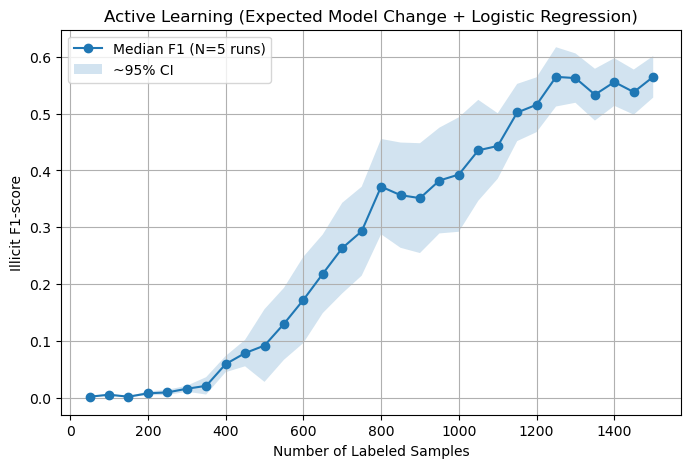

In [8]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Step 1: Load labeled data
labeled_df = pd.read_csv('elliptic_txs_features_labeled.csv')

# Step 2: Split data
train_df = labeled_df[labeled_df['time_step'] <= 34].reset_index(drop=True)
test_df = labeled_df[labeled_df['time_step'] >= 35].reset_index(drop=True)

X_test = test_df.drop(columns=['txId', 'time_step', 'class'])
y_test = (test_df['class'] == 1).astype(int)

feature_columns = [col for col in train_df.columns if col.startswith('feature_') or col.startswith('f')]

# Step 3: Config
batch_size = 50
max_iterations = 30
N_runs = 5
all_f1_scores = []

# Step 4: Active Learning across N runs
for run in range(N_runs):
    print(f"\n=== Run {run+1}/{N_runs} ===")

    unlabeled_pool = train_df.copy()
    labeled_pool = pd.DataFrame(columns=train_df.columns)
    f1_scores = []

    # Warm-up via Isolation Forest
    iso_forest = IsolationForest(random_state=run+1)
    iso_forest.fit(unlabeled_pool[feature_columns])
    scores = -iso_forest.score_samples(unlabeled_pool[feature_columns])
    unlabeled_pool['anomaly_score'] = scores
    unlabeled_pool = unlabeled_pool.sort_values(by='anomaly_score', ascending=False).reset_index(drop=True)

    pointer = 0
    found_illicit = False
    while not found_illicit and pointer < len(unlabeled_pool):
        batch = unlabeled_pool.iloc[pointer:pointer+batch_size]
        labeled_pool = pd.concat([labeled_pool, batch], ignore_index=True)
        pointer += batch_size
        found_illicit = (labeled_pool['class'] == 1).sum() > 0

    warmup_count = len(labeled_pool)
    print(f"Warm-up selected {warmup_count} samples. Found illicit: {(labeled_pool['class'] == 1).sum()}")

    unlabeled_pool = unlabeled_pool.iloc[pointer:].drop(columns='anomaly_score').reset_index(drop=True)

    # Active Learning loop
    iteration = 1
    active_selected = 0
    while len(unlabeled_pool) > 0 and iteration <= max_iterations:
        X_train = labeled_pool[feature_columns]
        y_train = (labeled_pool['class'] == 1).astype(int)

        lr_model = LogisticRegression(max_iter=1000, solver='lbfgs', random_state=run+1)
        lr_model.fit(X_train, y_train)

        y_pred = lr_model.predict(X_test)
        f1 = f1_score(y_test, y_pred, pos_label=1)
        f1_scores.append(f1)
        print(f"[Run {run+1}] Iteration {iteration:02d} - F1 illicit: {f1:.4f}")

        # Expected Model Change strategy
        probs = lr_model.predict_proba(unlabeled_pool[feature_columns])
        grads = probs[:, 1] * (1 - probs[:, 1])  # ∂L approx
        emc_score = grads

        select_idx = np.argsort(emc_score)[-batch_size:]
        new_batch = unlabeled_pool.iloc[select_idx]

        labeled_pool = pd.concat([labeled_pool, new_batch], ignore_index=True)
        unlabeled_pool = unlabeled_pool.drop(unlabeled_pool.index[select_idx]).reset_index(drop=True)

        active_selected += len(new_batch)
        iteration += 1

    total_final_train = len(labeled_pool)
    all_f1_scores.append(f1_scores)

    run_median = np.median(f1_scores)
    print(f"[Run {run+1}] Median F1 illicit: {run_median:.4f}")
    print(f"[Run {run+1}] Active Learning selected {active_selected} samples.")
    print(f"[Run {run+1}] Final training set size: {total_final_train} samples.")

# Step 5: Convert to matrix
f1_matrix = np.full((N_runs, max_iterations), np.nan)
for i, scores in enumerate(all_f1_scores):
    f1_matrix[i, :len(scores)] = scores

# Step 6: Print each iteration's average across 5 runs
mean_f1_by_iteration = np.nanmean(f1_matrix, axis=0)
print("\n=== Mean F1 illicit across 5 runs ===")
for i, mean_f1 in enumerate(mean_f1_by_iteration):
    print(f"Iteration {i+1:02d} ({(i+1)*batch_size} samples): Mean F1 = {mean_f1:.4f}")

# Step 7: Final evaluation per paper
final_f1s = f1_matrix[:, -1]
median_final_f1 = np.nanmedian(final_f1s)
std_final_f1 = np.nanstd(final_f1s)
ci_95 = 1.57 * std_final_f1 / np.sqrt(N_runs)

print(f"\n===== Final Evaluation (Paper style) =====")
print(f"Median Final F1 illicit (last iteration): {median_final_f1:.4f}")
print(f"~95% Confidence Interval: ±{ci_95:.4f}")

# Step 8: Plot
median_curve = np.nanmedian(f1_matrix, axis=0)
std_curve = np.nanstd(f1_matrix, axis=0)
ci_95_curve = 1.57 * std_curve / np.sqrt(N_runs)
x_axis = np.arange(1, len(median_curve)+1) * batch_size

plt.figure(figsize=(8, 5))
plt.plot(x_axis, median_curve, marker='o', label='Median F1 (N=5 runs)')
plt.fill_between(x_axis, median_curve - ci_95_curve, median_curve + ci_95_curve, alpha=0.2, label='~95% CI')
plt.title("Active Learning (Expected Model Change + Logistic Regression)")
plt.xlabel("Number of Labeled Samples")
plt.ylabel("Illicit F1-score")
plt.legend()
plt.grid(True)
plt.show()
